In [1]:
import os
import numpy as np 
import pandas as pd 
import warnings
from tools.test_bias import test_bias, train_test_bias
from tools.plotting import plot_bias
from tools.bias_utils import add_demographic_data
from tools.loss_functions import get_distance_corrected_mse, get_pearson_corrected_mse, get_kendalls_corrected_mse
from xgb_gradient_boosted_trees.gradient_boosted_trees import GradientBoostedTreesModel
from xgb_random_forest.random_forest import RandomForestModel
import json
import xgboost as xgb
warnings.filterwarnings("ignore")
# add directory to path
import sys
sys.path.append('./tools/compiled_loss_funcs')

/Users/ebensen/opt/anaconda3/envs/ai_bias/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Setup Parameters

In [2]:
cutoff = 2.0
correction = 'pearson' 
demographic = 'MINRTY'
model_type = 'xgb'
train = False

In [3]:
def logit(p):
    return np.log(p/(1-p))

def inv_logit(x):
    return 1/(1+np.exp(-x))

In [4]:
model_dict = {'rf': RandomForestModel, 'gbt': GradientBoostedTreesModel}
loss_dict = {'pearson': get_pearson_corrected_mse, 'kendall': get_kendalls_corrected_mse, 'distance': get_distance_corrected_mse}
path = os.path.join('results', f'results_{cutoff}', model_type, correction, demographic)
# Load params
with open(os.path.join(path, 'params.json')) as f:
    params = json.load(f)
with open(os.path.join(path, 'gamma_params.json')) as f:
    correction_gamma = inv_logit(json.load(f)["correction_gamma"])
print(params)
print(correction_gamma)

{'colsample': 0.5046222826346425, 'depth': 6.762016937259618, 'g': -2.507263079059758, 'min_cw': 6.548703117120763, 'n': 7.575535894239051, 'p': -1.7192186836318948, 'subsample': 0.9137143367164389}
0.9965771131281612


# Load Data

In [5]:
cols_drop = ['Date', 'FC', 'PenRate', 'NumberOfLanes', 'Dir', 'Lat', 'Long']

raw_data_train = pd.read_csv("./data/final_train_data.csv")
raw_data_test = pd.read_csv("./data/final_test_data.csv")
raw_data_test1 = pd.DataFrame(np.concatenate((raw_data_test.values, np.zeros(raw_data_test.shape[0]).reshape(-1, 1)), axis=1),
                                columns = raw_data_test.columns.append(pd.Index(['fold'])))
raw_data = pd.DataFrame(np.concatenate((raw_data_train.values, raw_data_test1.values), axis=0), 
                        columns = raw_data_train.columns)

raw_data = add_demographic_data(raw_data, demographic)
raw_data = raw_data.dropna()
raw_data_train = raw_data.loc[raw_data.fold!=0, :]
raw_data_test = raw_data.loc[raw_data.fold==0, :]
data = raw_data.drop(cols_drop, axis=1)
if 'Dir' in data.columns:
    one_hot = pd.get_dummies(data[['Dir']])
    data = data.drop(['Dir'], axis = 1)
    data = data.join(one_hot)
week_dict = {"DayOfWeek": {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 
                            'Friday': 5, 'Saturday': 6, 'Sunday': 7}}
data = data.replace(week_dict)

X = data.drop(['Volume'], axis=1)
y = data[['Volume']]

X_train = X.loc[X.fold!=0, :]
dem_train = X_train[[demographic]].values
fold_train = X_train[['fold']].values.reshape(-1)
train_ids = X_train[['StationId']].values.reshape((len(X_train), 1))
X_col = X_train.drop(['fold', 'StationId'], axis = 1).columns
X_train = X_train.drop(['fold', 'StationId'], axis = 1).values
y_train = y.loc[X.fold!=0, :].values

X_test = X.loc[X.fold==0, :]
dem_test = X_test[[demographic]].values
test_ids = X_test[['StationId']].values.reshape((len(X_test), 1))
X_test = X_test.drop(['fold', 'StationId'], axis = 1).values
y_test = y.loc[X.fold==0, :].values

In [6]:
def to_dmatrix(X, y):
        # get number of columns of np array X
        n_cols = X.shape[1]
        weights = [1.0 for _ in range(n_cols-1)] + [0.0]
        return xgb.DMatrix(X, label=y, feature_weights=weights)

In [7]:
dtrain = to_dmatrix(X_train, y_train)
dtest = to_dmatrix(X_test, y_test)

# Train Model

In [8]:
n_jobs = -1
objective = loss_dict[correction](correction_gamma, etype=0, compiled=True)
objective_uncorrected = get_pearson_corrected_mse(0.0, etype=0, compiled=True)
corrected_path = os.path.join(path, 'corrected.model')
if model_type == 'xgb':
    base_name = 'base_xgb.model'
elif model_type == 'rf':
    base_name = 'base_rf.model'
elif model_type == 'gbt':
    base_name = 'base_gbt.model'

base_path = os.path.join('.', 'base_models', model_type, base_name)
if not os.path.exists(corrected_path) or not os.path.exists(base_path) or train:
    print('No model found, retraining...')
    train = True # Force training if no saved model

if model_type == 'xgb':
    n_estimators = 100*int(params['n'])
    lr = 10**params['p']
    depth = int(params['depth'])
    gamma = 10**params['g']
    subsample = params['subsample']
    colsample = params['colsample']
    min_cw = params['min_cw']
    params = {'learning_rate':lr, 'max_depth':depth, 'n_jobs':n_jobs, 'gamma':gamma, 'min_child_weight':min_cw,
        'subsample':subsample, 'colsample_bytree':colsample, 'random_state':1234}
    model_uncorrected = xgb.Booster(params)
    model_uncorrected.load_model(base_path)
    if train:
        model_corrected = xgb.train(params, dtrain, num_boost_round=n_estimators, obj=objective)
        model_uncorrected = xgb.train(params, dtrain, num_boost_round=n_estimators, obj=objective_uncorrected)
        model_corrected.save_model(corrected_path)
    else:
        model_corrected = xgb.Booster(params)
        model_corrected.load_model(corrected_path)
elif model_type == 'rf':
    n_estimators = 100*int(params['n'])
    depth = int(params['depth'])
    gamma = 10**params['g']
    min_cw = params['min_cw']
    subsample = params['subsample']
    colsample = params['colsample']
    params = {'n_estimators':n_estimators, 'max_depth':depth, 'nthread':n_jobs, 'gamma':gamma, 'min_child_weight':min_cw,
                'subsample':subsample, 'colsample_bytree':colsample, 'random_state':1234}
    model_uncorrected = RandomForestModel(**params)
    model_uncorrected.load_model(base_path)
    if train:
        model_corrected = RandomForestModel(**params)
        model_corrected.train(dtrain, obj=objective)
        model_corrected.save_model(corrected_path)
    else:
        model_corrected = RandomForestModel(**params)
        model_corrected.load_model(corrected_path)
elif model_type == 'gbt':
    n_estimators = 100*int(params['n'])
    lr = 10**params['p']
    depth = int(params['depth'])
    min_cw = params['min_cw']
    subsample = params['subsample']
    colsample = params['colsample']
    params = {'num_boost_round':n_estimators, 'eta':lr, 'max_depth':depth, 'nthread':n_jobs, 'min_child_weight':min_cw,
                        'subsample':subsample, 'colsample_bytree':colsample, 'random_state':1234}
    model_uncorrected = GradientBoostedTreesModel(**params)
    model_uncorrected.load_model(base_path)
    if train:
        model_corrected = GradientBoostedTreesModel(**params)
        model_corrected.train(dtrain, obj=objective)
        model_corrected.save_model(corrected_path)
    else:
        model_corrected = GradientBoostedTreesModel(**params)
        model_corrected.load_model(corrected_path)
else:
    raise ValueError('Model type not recognized')

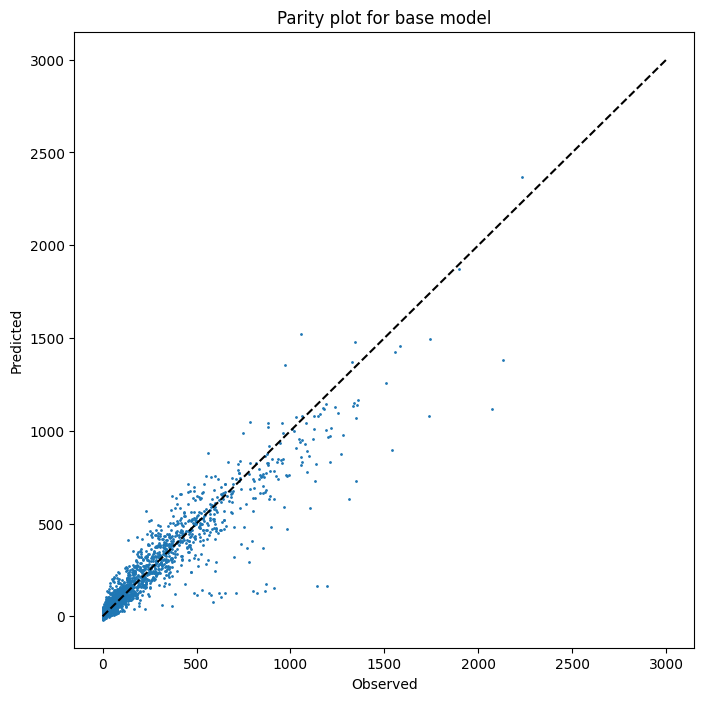

In [9]:
# Parity plot for base model
import matplotlib.pyplot as plt
y_pred = model_uncorrected.predict(dtest)
y_pred = y_pred.reshape((len(y_pred), 1))
y_test = y_test.reshape((len(y_test), 1))

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, s=1)
plt.plot([0, 3000], [0, 3000], 'k--')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Parity plot for base model')
plt.savefig(os.path.join(path, 'parity_base.png'))
# plt.xscale('log')
# plt.yscale('log')
plt.show()

# Test Bias

In [10]:
base_path = os.path.join('.', 'base_models', model_type, f'{model_type}_bias_data.csv')
if not os.path.exists(base_path):
    bias_data = test_bias(model_uncorrected, dtest, dem_test)
else:
    bias_data = pd.read_csv(base_path)
    demrows = [f'{demographic}_0.{i}' for i in range(6,10)]
    bias_data = bias_data.loc[bias_data['Demographic'].isin(demrows), :]

corrected_path = os.path.join(path, 'bias.csv')
if not os.path.exists(corrected_path):
    bias_data_corrected = test_bias(model_corrected, dtest, dem_test)
else:
    bias_data_corrected = pd.read_csv(corrected_path)

In [11]:
bias_data

,Demographic,r2_0,r2_1,pval,fdr_corrected_pval,r2_diff,Sig at 0.05,Sig at 0.01,Sig at 0.001
24,MINRTY_0.6,0.921959,0.813226,0.0002,0.000706,0.108733,True,True,True
25,MINRTY_0.7,0.919047,0.797973,0.0000,0.000000,0.121074,True,True,True
26,MINRTY_0.8,0.905055,0.683166,0.0000,0.000000,0.221889,True,True,True
27,MINRTY_0.9,0.903778,0.476181,0.0000,0.000000,0.427596,True,True,True


In [12]:
bias_data_corrected

,Demographic,r2_0,r2_1,pval,fdr_corrected_pval,r2_diff,Sig at 0.05,Sig at 0.01,Sig at 0.001
0,Demographic_0.6,0.685655,0.628628,0.0822,0.1096,0.057027,False,False,False
1,Demographic_0.7,0.665026,0.616880,0.1365,0.1365,0.048147,False,False,False
2,Demographic_0.8,0.674250,0.544700,0.0008,0.0016,0.129549,True,True,False
3,Demographic_0.9,0.677514,0.407154,0.0000,0.0000,0.270360,True,True,True


In [13]:
plot_data = pd.concat([bias_data, bias_data_corrected], axis=0).reset_index(drop=True)
plot_data

,Demographic,r2_0,r2_1,pval,fdr_corrected_pval,r2_diff,Sig at 0.05,Sig at 0.01,Sig at 0.001
0,MINRTY_0.6,0.921959,0.813226,0.0002,0.000706,0.108733,True,True,True
1,MINRTY_0.7,0.919047,0.797973,0.0000,0.000000,0.121074,True,True,True
2,MINRTY_0.8,0.905055,0.683166,0.0000,0.000000,0.221889,True,True,True
3,MINRTY_0.9,0.903778,0.476181,0.0000,0.000000,0.427596,True,True,True
4,Demographic_0.6,0.685655,0.628628,0.0822,0.109600,0.057027,False,False,False
5,Demographic_0.7,0.665026,0.616880,0.1365,0.136500,0.048147,False,False,False
6,Demographic_0.8,0.674250,0.544700,0.0008,0.001600,0.129549,True,True,False
7,Demographic_0.9,0.677514,0.407154,0.0000,0.000000,0.270360,True,True,True


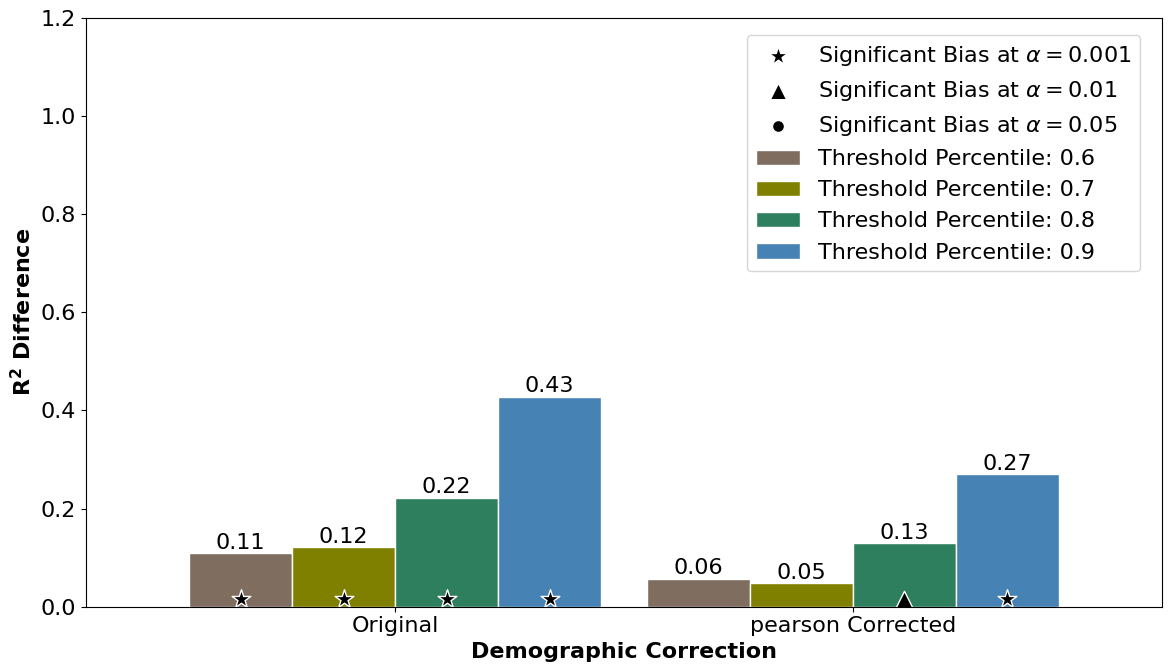

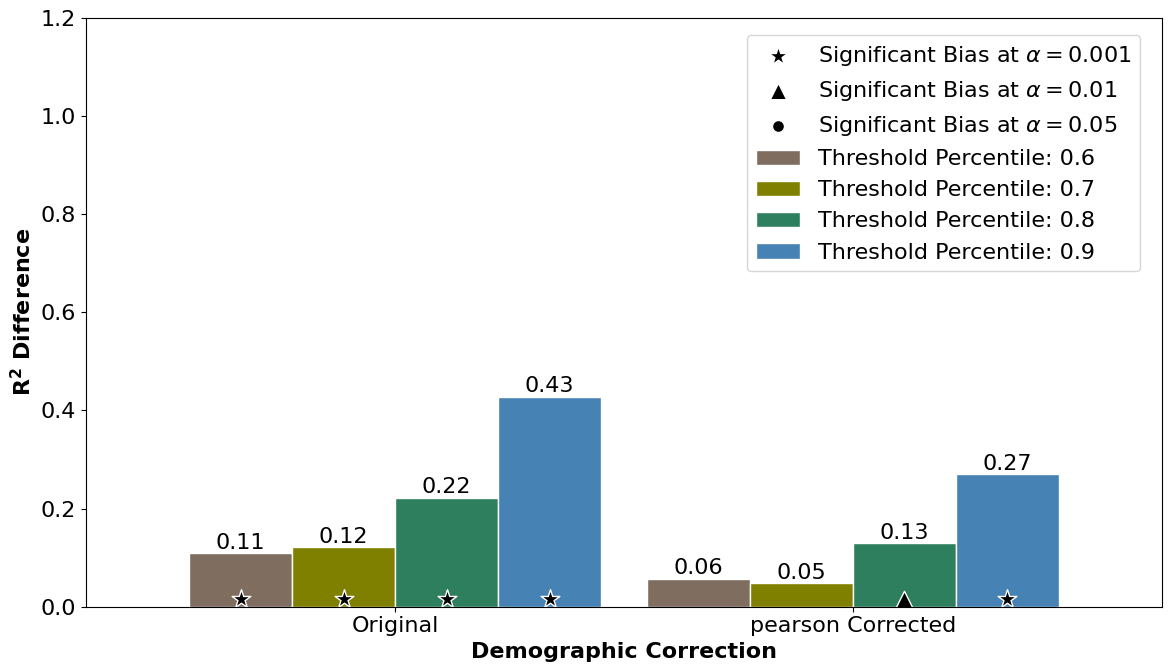

In [14]:
labels = ['Original', f'{correction} Corrected']
ylim=(0, 1.2)
plot_bias(plot_data, labels, savepath=os.path.join(path, 'bias_testing.jpg'), ylim=ylim)